# MS3 - Baseline: Resnet50 + FCN
Authors: Harry Li, Yunxi Li, John Jun, Valentin Badea

### Installs and Imports

Here we will load necessary packages and any overhead installs required for the data access

In [236]:
import os
import sys
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import pearsonr, ConstantInputWarning
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score
import scipy.stats as stats

import spatialdata as sd 
import anndata as ad 
import scanpy as sc 
from skimage.measure import regionprops
import h5py

import torch
import timm 
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn as nn

import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

### Data Loading

Loads in and stores the data objects in this note book for easier acess, might require some large memory

In [2]:
sdata = sd.read_zarr('raw/UC6_I.zarr/UC6_I.zarr')

/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [156]:
class PatchCells(Dataset):
    """
    This class takes in an histology image, 
    list of cell ids that is supposedly in that image
    a dictionary that maps cell ids to their centroid coordinates,
    and a patch size. 
    """
    def __init__(self, image, cell_ids, cell_coords, patch_size=32):
        self.image = image
        self.cell_ids = cell_ids
        self.cell_coords = cell_coords
        self.patch_size = patch_size

    # do a filtering of the cell ids
        self.valid_cell_ids = [id for id in cell_ids if id in cell_coords]

    def __len__(self):
        return len(self.valid_cell_ids)
        
    # takes in a cell id, returns a {key: cell id, value: patch in tensor format}
    def __getitem__(self, idx):
        cell_id = self.valid_cell_ids[idx]
        x, y = self.cell_coords[cell_id]

        half_patch = self.patch_size // 2

        # taking care of edge cases as well
        x_start = max(0, x - half_patch)
        x_end = min(self.image.shape[0], x + half_patch)
        y_start = max(0, y - half_patch)
        y_end = min(self.image.shape[1], y + half_patch)

        # create a 0 patch first
        patch = np.zeros((self.patch_size, self.patch_size, 3), dtype=np.float32)

        # populate with actual data, note the case where cell is at edge of image
        patch_from_in = self.image[y_start:y_end, x_start:x_end]
        patch[:patch_from_in.shape[0], :patch_from_in.shape[1], :] = patch_from_in 

        # normalize
        patch = patch / 255.0

        # pytorch tensor
        patch = np.transpose(patch, (2, 0, 1))

        return {
            'cell_id': cell_id,
            'patch': torch.tensor(patch, dtype=torch.float32)
        }
    
# pairs cell ids (according to the split we want) to their patches
# returns a dictionary of {key: cell id, value: patch} (same as PatchCells)
def get_patches(sdata, random_seed=209):
    # pull training cells ids into a list
    split_cell_id = sdata["cell_id-group"].obs.query("group == 'train'")["cell_id"].values

    # get mask, pull regions
    he_nuc_mask = sdata['HE_nuc_original'][0, :, :].to_numpy()
    regions = regionprops(he_nuc_mask)

    # pull centroid coordinate of each cell's regions
    # dict has key=cell id and value=centroid coordinate
    cell_coords = {}
    for props in regions:
        cid = props.label
        if cid in split_cell_id:
            y_center, x_center = int(props.centroid[0]), int(props.centroid[1])
            cell_coords[cid] = (x_center, y_center)

    # assemble the patch dataset
    he_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    np.random.seed(random_seed)
    shuffled = np.random.permutation(split_cell_id)
    total_len = len(split_cell_id)
    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    train_ids = shuffled[:train_len]
    val_ids = shuffled[train_len:train_len + val_len]
    test_ids = shuffled[train_len + val_len:]

    # create dataset objects
    dataset_patch_train = PatchCells(he_image, train_ids, cell_coords, patch_size=32)
    dataset_patch_val = PatchCells(he_image, val_ids, cell_coords, patch_size=32)
    dataset_patch_test = PatchCells(he_image, test_ids, cell_coords, patch_size=32)

    return dataset_patch_train, dataset_patch_val, dataset_patch_test

def get_expression(sdata, dataset_patch):
    # get expression data
    gene_names = sdata['anucleus'].var['gene_symbols'].values
    gene_exp_matrix = sdata['anucleus'].X

    # need to pair up cell id with the cell's index in expression matrix
    cell_id_to_idx = {cell_id: i for i, cell_id in enumerate(sdata['anucleus'].obs['cell_id'].values)}
    valid_cell_ids = dataset_patch.valid_cell_ids
    valid_cell_idx = [cell_id_to_idx[cell_id] for cell_id in valid_cell_ids if cell_id in cell_id_to_idx] # taking the intercept just in case

    # subset expression matrix by filtered cell
    dataset_expression = gene_exp_matrix[valid_cell_idx]

    if sp.issparse(dataset_expression):
        dataset_expression = dataset_expression.toarray()
    return dataset_expression

def extract_features(loader, model):
    features = []
    cell_ids = []

    with torch.no_grad():
        for batch in loader:
            patches = batch['patch'].to('cuda')
            output = model(patches)
            
            # reshape
            output = output.squeeze()
            
            features.append(output.cpu().numpy())
            cell_ids.extend(batch['cell_id'])
    
    features = np.vstack(features)
    feature_cell_ids = np.array(cell_ids)
    return features, feature_cell_ids

# calculate r2 and pearson given y pred and y true
def compute_r2_pearson(y_true, y_pred):
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # r2 is easy we average across samples
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')

    # pearson we have to query each gene
    pearson = []
    for i in range(y_true.shape[1]):
        corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
        pearson.append(corr)
    mean_pearson = np.nanmean(pearson)

    return r2, mean_pearson

### Fit a simple FCN

In [152]:
# create train and val datasets
dataset_patch_train, dataset_patch_val, dataset_patch_test = get_patches(sdata)
dataset_expression_train = get_expression(sdata, dataset_patch_train)
dataset_expression_val = get_expression(sdata, dataset_patch_val)
dataset_expression_test = get_expression(sdata, dataset_patch_test)

# create dataloader
train_loader = DataLoader(dataset_patch_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_patch_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_patch_test, batch_size=32, shuffle=True)

# define resnet model
# pull resnet50, throw away last layer
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
model_resnet = torch.nn.Sequential(*(list(model_resnet.children())[:-1]))
model_resnet.to('cuda')
model_resnet.eval()

# extract resnet embeddings
train_embeddings, train_cell_ids = extract_features(train_loader, model_resnet)
val_embeddings, val_cell_ids = extract_features(val_loader, model_resnet)
test_embeddings, test_cell_ids = extract_features(test_loader, model_resnet)

In [153]:
train_dataset = TensorDataset(
    torch.tensor(train_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_train, dtype=torch.float32)
)

val_dataset = TensorDataset(
    torch.tensor(val_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_val, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(test_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_test, dtype=torch.float32) 
)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [157]:
# fit fcn model
resnet_feature_dim = train_embeddings.shape[1]
model = nn.Sequential(
    nn.Linear(resnet_feature_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 460)
)
model.to('cuda')

# some setups
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
val_losses = []

# es logic
best_r2 = float('inf')
patience = 5
counter = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # validation
    model.eval()
    running_val_loss = 0.0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to('cuda'), y_val.to('cuda')
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            running_val_loss += val_loss.item()

            y_true_all.append(y_val.cpu().numpy())
            y_pred_all.append(y_pred_val.cpu().numpy())
    val_losses.append(running_val_loss / len(val_loader))
    val_r2, val_pearson = compute_r2_pearson(y_true_all, y_pred_all)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val R2: {val_r2:.4f}, Val Pearson: {val_pearson:.4f}")
    
    if val_r2 < best_r2:
        best_r2 = val_r2
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# save the best model
model.load_state_dict(best_model_state)


Epoch 1, Train Loss: 0.1115, Val Loss: 0.1112, Val R2: -0.0016, Val Pearson: -0.0003
Epoch 2, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0002
Epoch 3, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0008, Val Pearson: 0.0006
Epoch 4, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0004
Epoch 5, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0010, Val Pearson: 0.0004
Epoch 6, Train Loss: 0.1110, Val Loss: 0.1111, Val R2: -0.0014, Val Pearson: 0.0006
Early stopping at epoch 6


<All keys matched successfully>

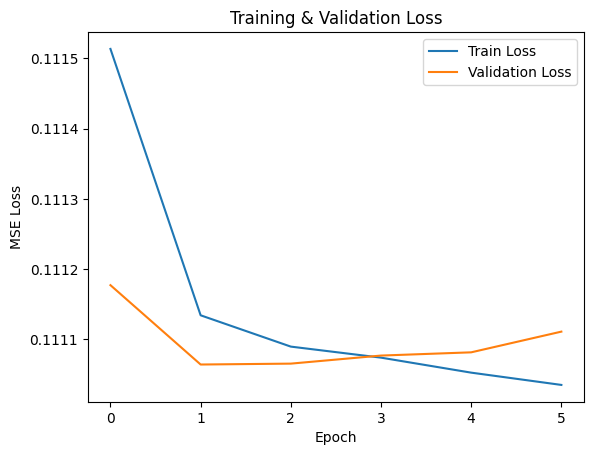

In [158]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [195]:
model.eval()
y_true_all, y_pred_all = [], []
x_test_all = []
test_loss = 0.0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
        y_pred_test = model(x_test)
        loss = criterion(y_pred_test, y_test)
        test_loss += loss.item()
        x_test_all.append(x_test.cpu().numpy())
        y_true_all.append(y_test.cpu().numpy())
        y_pred_all.append(y_pred_test.cpu().numpy())
test_loss /= len(test_loader)
test_r2, test_pearson = compute_r2_pearson(y_true_all, y_pred_all)
print(f"Test MSE Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}, Test Pearson: {test_pearson:.4f}")

Test MSE Loss: 0.1112, Test R2: -0.0011, Test Pearson: -0.0001


[[1.812902  0.        0.        ... 0.        0.        1.2709123]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        1.7814181 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 ...
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


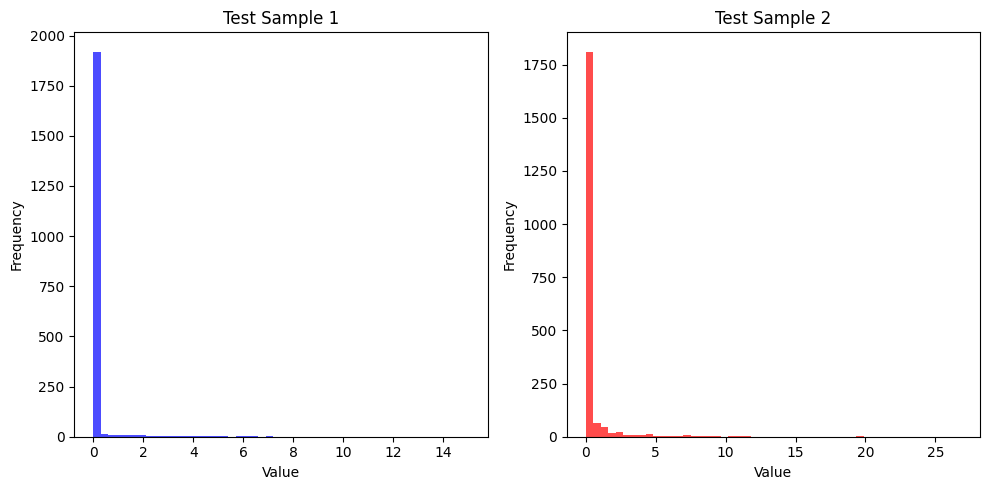

In [ ]:
# plot the two test samples as a histogram (they are embeddings)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_test_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(x_test_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

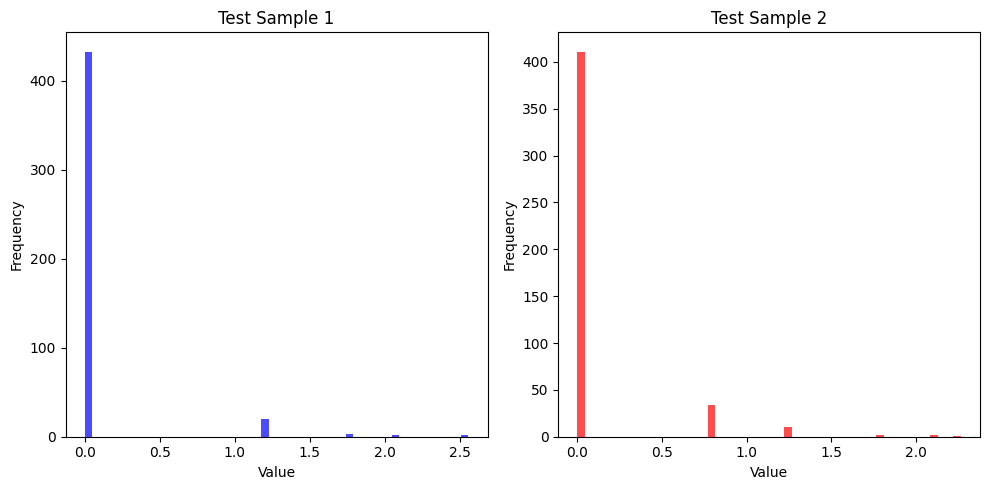

In [178]:
# plot the true expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(y_true_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(y_true_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

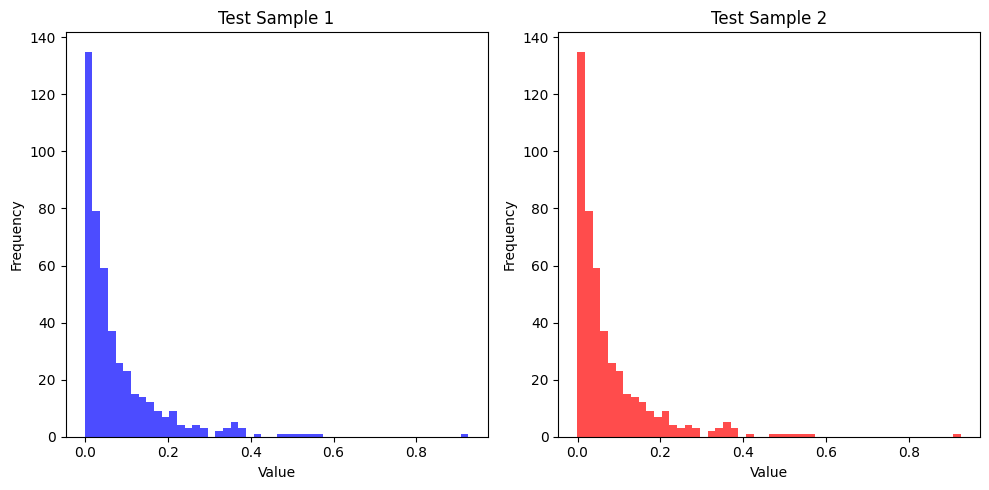

In [179]:
# plot the two predicted expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].hist(y_pred_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')  
axs[1].hist(y_pred_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [197]:
pearson = []
y_pred = np.vstack(y_pred_all)
y_true = np.vstack(y_true_all)
for i in range(y_true.shape[1]):
    corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
    pearson.append(corr)
mean_pearson = np.nanmean(pearson)

(460,)
(22379,)
R2 of expression vector:  0.020224690437316895
Pearson of expression vector:  0.18172315
R2 of some gene:  -9.548664093017578e-05
Pearson of some gene:  0.012561899


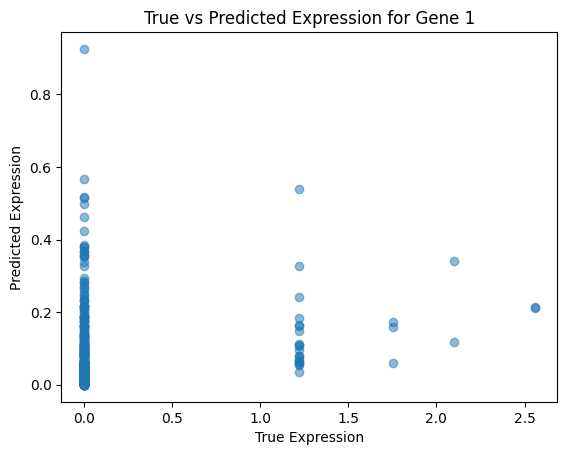

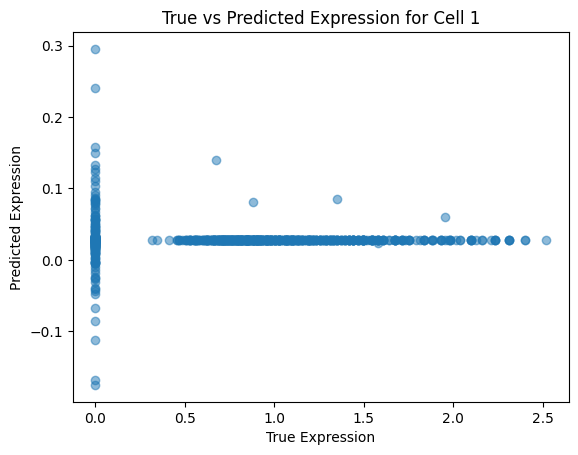

In [228]:
# print(y_pred[1,:])
print(y_true[1,:].shape)
print(y_pred[:,1].shape)

# r2 score of expression vectors
r2 = r2_score(y_true[1,:], y_pred[1,:])
p,_ = stats.pearsonr(y_true[1,:], y_pred[1,:])
print("R2 of expression vector: ", r2)
print("Pearson of expression vector: ", p)

r2 = r2_score(y_true[:,1], y_pred[:,1])
p,_ = stats.pearsonr(y_true[:,1], y_pred[:,1])
print("R2 of some gene: ", r2)
print("Pearson of some gene: ", p)

# plot the two predicted expressions of one test sample
plt.scatter(y_true[1,:], y_pred[1,:], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Gene 1')
plt.show()

# plot the two predicted expressions of one test sample
plt.scatter(y_true[:,1], y_pred[:,1], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Cell 1')
plt.show()

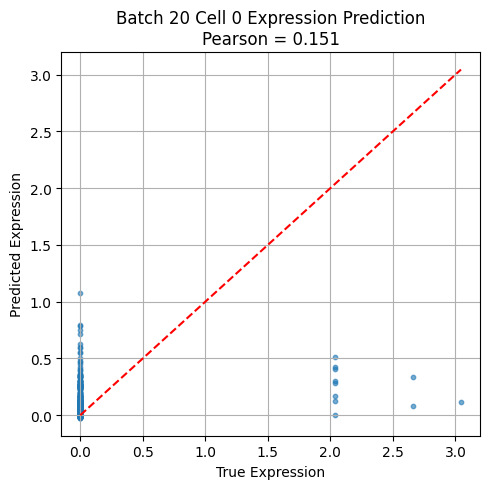

In [226]:
# Pick one cell (e.g., index 0)
batch_idx = 20
cell_idx = 0
y_true_vec = y_true_all[batch_idx][cell_idx]
y_pred_vec = y_pred_all[batch_idx][cell_idx]

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true_vec, y_pred_vec, alpha=0.6, s=10)
plt.plot([y_true_vec.min(), y_true_vec.max()], [y_true_vec.min(), y_true_vec.max()], 'r--')
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Batch {batch_idx} Cell {cell_idx} Expression Prediction\nPearson = {np.corrcoef(y_true_vec, y_pred_vec)[0,1]:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

(460,)
<class 'numpy.ndarray'>


/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


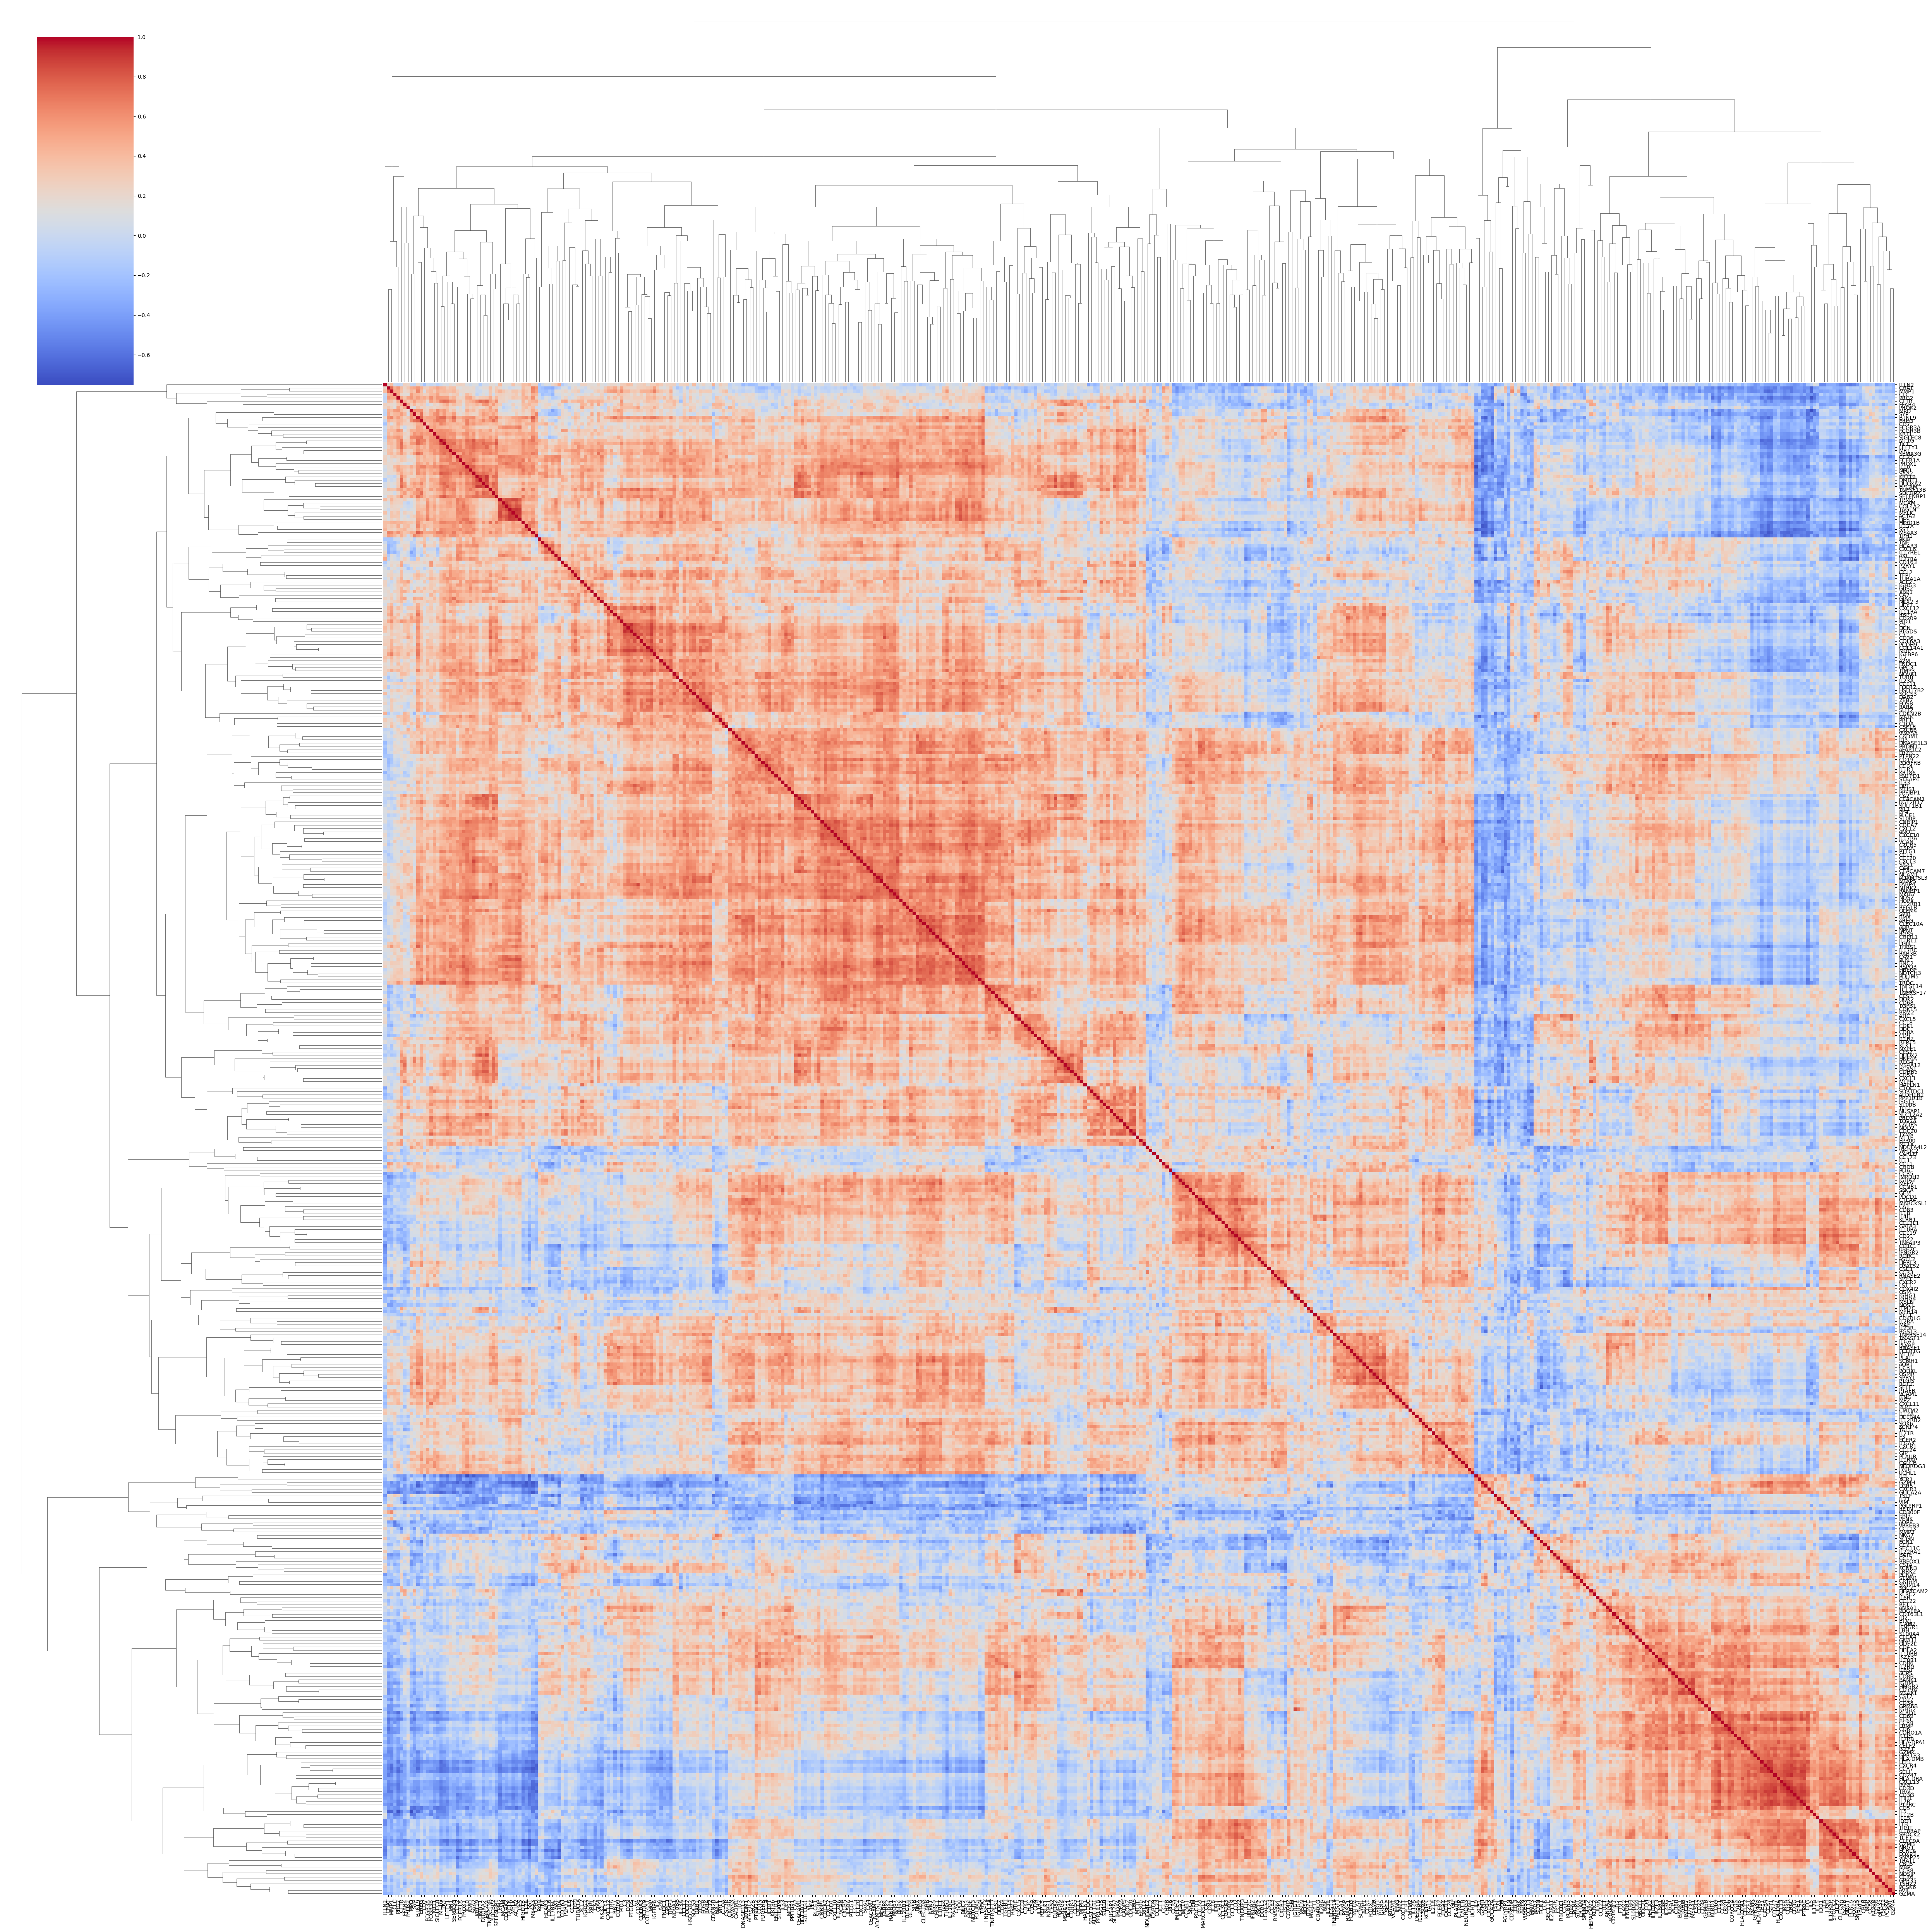

In [243]:
#can we use our prediction to make a gene heatmap??
# get the predicted expression for all cells
print(y_pred[1].shape)
print(type(y_pred))

gene_names = sdata['anucleus'].var['gene_symbols'].values
corr_matrix = np.corrcoef(y_pred.T)
# label with gene names and save a high resolution image, and enable clustering
sns.clustermap(
    corr_matrix,
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    xticklabels=gene_names,
    yticklabels=gene_names,
    figsize=(50, 50)
)

plt.savefig("gene_correlation_clustermap.png", dpi=300)
plt.show()

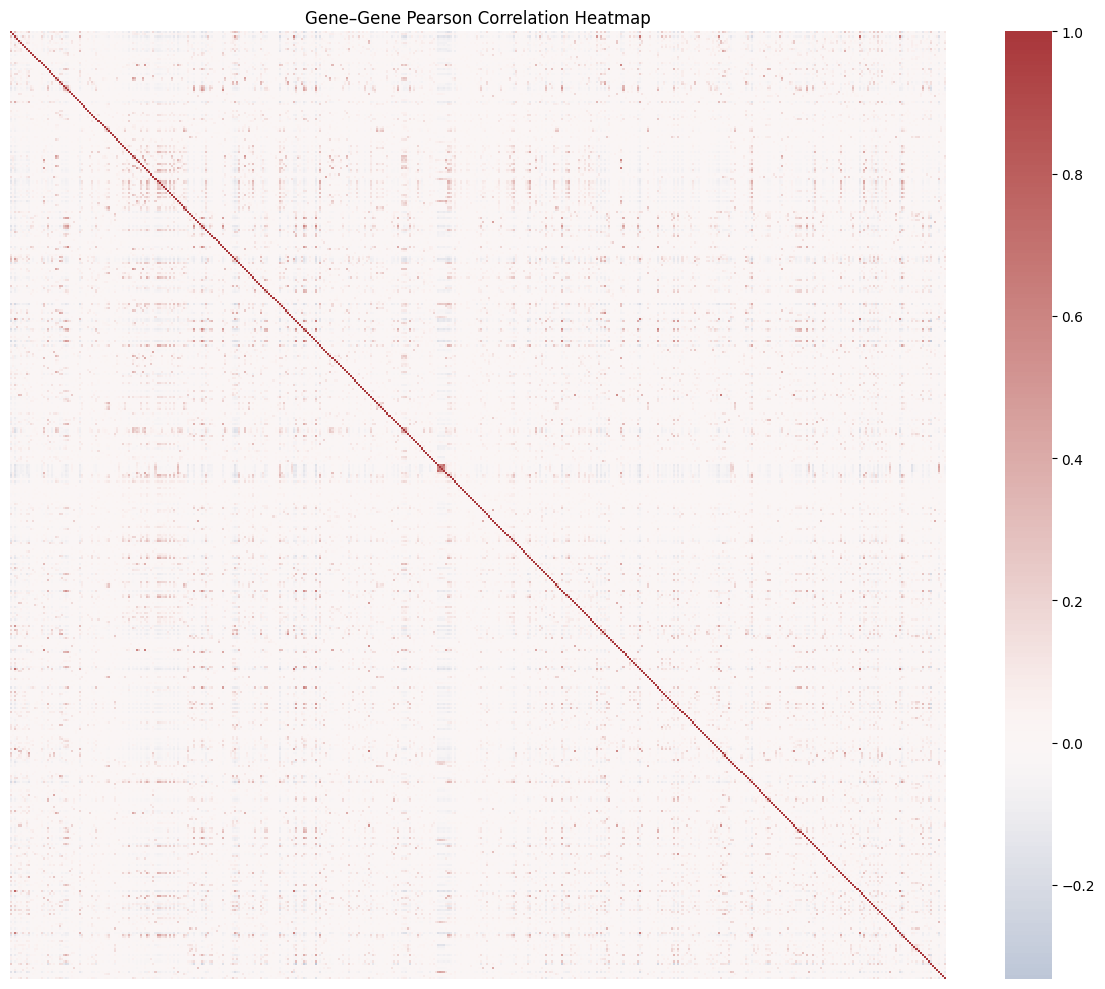

In [238]:
# now for the true expression??
corr_matrix = np.corrcoef(y_true.T)  # transpose: now shape (460, 460)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="vlag", center=0, xticklabels=False, yticklabels=False)
plt.title("Gene–Gene Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

## Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease